# Forecasting: get regression predictions for sepsis check

- physiological features only, no texts

- full dataset `pre_text_small`

- regression modeling/forecasting

## Hardware check

In [3]:
# gpu check
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [4]:
# check number of cores
import multiprocessing

cores = multiprocessing.cpu_count() 
cores

8

## Environment Prep

In [ ]:
# ! pip install pandas==1.3.4
# ! pip install tqdm==4.62.3
# ! pip install numpy==1.21.2
# ! pip install scikit-learn==0.24.2
# ! pip install scipy==1.7.1
# ! pip install setuptools==58.0.4
# ! pip install tensorflow==2.3.0

In [ ]:
! pip install pandas==1.3.4
! pip install tqdm==4.62.3
! pip install numpy==1.21.2
! pip install scikit-learn==0.24.2
! pip install scipy==1.7.1
! pip install setuptools==58.0.4
# # ! pip install sip==4.19.8
# # ! pip install six==1.16.0
# # ! pip install sqlite==3.36.0
# ! pip install tensorboard==1.15.0
# # ! pip install tensorflow==2.3.0
# ! pip install tensorflow-base==1.15.0
# ! pip install tensorflow-estimator==2.3.0
# # ! pip install tensorflow-gpu==1.15.0
# ! pip install tensorflow-gpu==2.3.0
! pip install tensorboard==1.15.0
! pip install tensorflow==2.3.0
! pip install tensorflow-base==1.15.0
! pip install tensorflow-estimator==2.3.0
! pip install tensorflow-gpu==1.15.0
# ! pip uninstall tensorflow tensorflow-gpu
# ! pip install tensorflow-gpu

In [4]:
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Lambda
from tensorflow.keras.models import Model
# from tensorflow.keras import models
import pickle
import numpy as np
from tqdm import tqdm
tqdm.pandas()
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import Callback, EarlyStopping
import pandas as pd
import json
from google.colab import files
from sklearn.model_selection import train_test_split
from collections import Counter
import smart_cond as sc

### Version Check

In [5]:
import tensorflow as tf
print(tf. __version__)

2.11.0


In [6]:
pickle.format_version

'4.0'

## Load Data

In [5]:
# connect to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
! unzip /content/drive/MyDrive/sepsis/strats_exp/data/sepsis_data/pre_text/pre_text_small.zip

Archive:  /content/drive/MyDrive/sepsis/strats_exp/data/sepsis_data/pre_text/pre_text_large.zip
   creating: forecasting_exp1/
  inflating: forecasting_exp1/mimic_iii_icu_forecasting1.csv  
  inflating: forecasting_exp1/mimic_iii_preprocessed_forecasting1.pkl  
  inflating: forecasting_exp1/mimic_iii_events_forecasting1.csv  


### load from pkl and preprocess data

In [9]:
# mortality data
data_path = '/content/forecasting_exp1/mimic_iii_preprocessed_forecasting1.pkl'
pkl = pickle.load(open(data_path, 'rb'))
# data, oc, train_ind, valid_ind, test_ind = pd.read_pickle(open(data_path, 'rb'))

data = pkl[0]
oc = pkl[1]
# 0.0 -> 1.0 to avoid exploding gradient (NaN loss of regression model)
data.loc[data['variable'] == 'Antibiotics', 'value'] = 1
data.loc[data['variable'] == 'Blood Culture', 'value'] = 1
data.loc[data['variable'] == 'Mechanically ventilated', 'value'] = 1
# delete overlapped variable due to typo in mortality data
data = data[data['variable'] != 'vacomycin']
# drop na to avoid exploding gradient
data = data.dropna()
oc = oc.dropna()

### Load indices

In [10]:
ids = oc['SUBJECT_ID'].tolist()
labels = oc['in_hospital_sepsis'].tolist()
new_patient_ids = []
new_labels = []
for i in range(len(labels)):
  # print(i)
  if ids[i] in new_patient_ids:
    continue
  else:
    new_patient_ids.append(ids[i])
    new_labels.append(labels[i])

x, x_test, y, y_test = train_test_split(new_patient_ids, new_labels, test_size=0.2, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=1)

 # train
train_ind = []
ts_ind = oc['ts_ind'].tolist()
# ids = ids
for i in range(len(ts_ind)):
  if ids[i] in x_train:
    train_ind.append(ts_ind[i])
test_ind = []
for i in range(len(ts_ind)):
  if ids[i] in x_test:
    test_ind.append(ts_ind[i])
# to np.array
test_ind = np.array(test_ind)
valid_ind = []
for i in range(len(ts_ind)):
  if ids[i] in x_val:
    valid_ind.append(ts_ind[i])
# to np.array
valid_ind = np.array(valid_ind)

### save preprocessed data to pkl

In [16]:
# save preprocessed data
pickle.dump([data, oc, train_ind, valid_ind, test_ind], open('sepsis_pretext_large_processed.pkl','wb'))

## Define metrics and losses

In [22]:
def get_res(y_true, y_pred):
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    pr_auc = auc(recall, precision)
    minrp = np.minimum(precision, recall).max()
    roc_auc = roc_auc_score(y_true, y_pred)
    return [roc_auc, pr_auc, minrp]

# ######################################################################################################## 
# ######################################################################################################## 
# class_weights = compute_class_weight(class_weight='balanced', classes=[0,1], y=train_op)
# def mortality_loss(y_true, y_pred):
#     sample_weights = (1-y_true)*class_weights[0] + y_true*class_weights[1]
#     bce = K.binary_crossentropy(y_true, y_pred)
#     return K.mean(sample_weights*bce, axis=-1)
# ######################################################################################################## 
# ######################################################################################################## 

# var_weights = np.sum(fore_train_op[:, V:], axis=0)
# var_weights[var_weights==0] = var_weights.max()
# var_weights = var_weights.max()/var_weights
# var_weights = var_weights.reshape((1, V))
def forecast_loss(y_true, y_pred):
    return K.sum(y_true[:,V:]*(y_true[:,:V]-y_pred)**2, axis=-1)

def get_min_loss(weight):
    def min_loss(y_true, y_pred):
        return weight*y_pred
    return min_loss

class CustomCallback(Callback):
    def __init__(self, validation_data, batch_size):
        self.val_x, self.val_y = validation_data
        self.batch_size = batch_size
        super(Callback, self).__init__()

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.val_x, verbose=0, batch_size=self.batch_size)
        if type(y_pred)==type([]):
            y_pred = y_pred[0]
        precision, recall, thresholds = precision_recall_curve(self.val_y, y_pred)
        pr_auc = auc(recall, precision)
        roc_auc = roc_auc_score(self.val_y, y_pred)
        logs['custom_metric'] = pr_auc + roc_auc
        print ('val_aucs:', pr_auc, roc_auc)

## Define model architecture

In [23]:
import tensorflow as tf
import numpy as np
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Embedding, Activation, Dropout, Softmax, Layer, InputSpec, Input, Dense, Lambda, TimeDistributed, Concatenate, Add
from tensorflow.keras import initializers, regularizers, constraints, Model
from tensorflow.python.keras.utils import tf_utils
from tensorflow.python.ops import array_ops
from tensorflow import nn

    
class CVE(Layer):
    def __init__(self, hid_units, output_dim):
        self.hid_units = hid_units
        self.output_dim = output_dim
        super(CVE, self).__init__()
        
    def build(self, input_shape): 
        self.W1 = self.add_weight(name='CVE_W1',
                            shape=(1, self.hid_units),
                            initializer='glorot_uniform',
                            trainable=True)
        self.b1 = self.add_weight(name='CVE_b1',
                            shape=(self.hid_units,),
                            initializer='zeros',
                            trainable=True)
        self.W2 = self.add_weight(name='CVE_W2',
                            shape=(self.hid_units, self.output_dim),
                            initializer='glorot_uniform',
                            trainable=True)
        super(CVE, self).build(input_shape)
        
    def call(self, x):
        x = K.expand_dims(x, axis=-1)
        x = K.dot(K.tanh(K.bias_add(K.dot(x, self.W1), self.b1)), self.W2)
        return x
        
    def compute_output_shape(self, input_shape):
        return input_shape + (self.output_dim,)
    
    
class Attention(Layer):
    
    def __init__(self, hid_dim):
        self.hid_dim = hid_dim
        super(Attention, self).__init__()

    def build(self, input_shape):
        d = input_shape.as_list()[-1]
        self.W = self.add_weight(shape=(d, self.hid_dim), name='Att_W',
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.b = self.add_weight(shape=(self.hid_dim,), name='Att_b',
                                 initializer='zeros',
                                 trainable=True)
        self.u = self.add_weight(shape=(self.hid_dim,1), name='Att_u',
                                 initializer='glorot_uniform',
                                 trainable=True)
        super(Attention, self).build(input_shape)
        
    def call(self, x, mask, mask_value=-1e30):
        attn_weights = K.dot(K.tanh(K.bias_add(K.dot(x,self.W), self.b)), self.u)
        mask = K.expand_dims(mask, axis=-1)
        attn_weights = mask*attn_weights + (1-mask)*mask_value
        attn_weights = K.softmax(attn_weights, axis=-2)
        return attn_weights
        
    def compute_output_shape(self, input_shape):
        return input_shape[:-1] + (1,)
    
    
class Transformer(Layer):
    
    def __init__(self, N=2, h=8, dk=None, dv=None, dff=None, dropout=0):
        self.N, self.h, self.dk, self.dv, self.dff, self.dropout = N, h, dk, dv, dff, dropout
        self.epsilon = K.epsilon() * K.epsilon()
        super(Transformer, self).__init__()

    def build(self, input_shape):
        d = input_shape.as_list()[-1]
        if self.dk==None:
            self.dk = d//self.h
        if self.dv==None:
            self.dv = d//self.h
        if self.dff==None:
            self.dff = 2*d
        self.Wq = self.add_weight(shape=(self.N, self.h, d, self.dk), name='Wq',
                                 initializer='glorot_uniform', trainable=True)
        self.Wk = self.add_weight(shape=(self.N, self.h, d, self.dk), name='Wk',
                                 initializer='glorot_uniform', trainable=True)
        self.Wv = self.add_weight(shape=(self.N, self.h, d, self.dv), name='Wv',
                                 initializer='glorot_uniform', trainable=True)
        self.Wo = self.add_weight(shape=(self.N, self.dv*self.h, d), name='Wo',
                                 initializer='glorot_uniform', trainable=True)
        self.W1 = self.add_weight(shape=(self.N, d, self.dff), name='W1',
                                 initializer='glorot_uniform', trainable=True)
        self.b1 = self.add_weight(shape=(self.N, self.dff), name='b1',
                                 initializer='zeros', trainable=True)
        self.W2 = self.add_weight(shape=(self.N, self.dff, d), name='W2',
                                 initializer='glorot_uniform', trainable=True)
        self.b2 = self.add_weight(shape=(self.N, d), name='b2',
                                 initializer='zeros', trainable=True)
        self.gamma = self.add_weight(shape=(2*self.N,), name='gamma',
                                 initializer='ones', trainable=True)
        self.beta = self.add_weight(shape=(2*self.N,), name='beta',
                                 initializer='zeros', trainable=True)
        super(Transformer, self).build(input_shape)
        
    def call(self, x, mask, mask_value=-1e-30):
        mask = K.expand_dims(mask, axis=-2)
        for i in range(self.N):
            # MHA
            mha_ops = []
            for j in range(self.h):
                q = K.dot(x, self.Wq[i,j,:,:])
                k = K.permute_dimensions(K.dot(x, self.Wk[i,j,:,:]), (0,2,1))
                v = K.dot(x, self.Wv[i,j,:,:])
                A = K.batch_dot(q,k)
                # Mask unobserved steps.
                A = mask*A + (1-mask)*mask_value
                # Mask for attention dropout.
                def dropped_A():
                    dp_mask = K.cast((K.random_uniform(shape=array_ops.shape(A))>=self.dropout), K.floatx())
                    return A*dp_mask + (1-dp_mask)*mask_value
                A = sc.smart_cond(K.learning_phase(), dropped_A, lambda: array_ops.identity(A))
                A = K.softmax(A, axis=-1)
                mha_ops.append(K.batch_dot(A,v))
            conc = K.concatenate(mha_ops, axis=-1)
            proj = K.dot(conc, self.Wo[i,:,:])
            # Dropout.
            proj = sc.smart_cond(K.learning_phase(), lambda: array_ops.identity(nn.dropout(proj, rate=self.dropout)),\
                                       lambda: array_ops.identity(proj))
            # Add & LN
            x = x+proj
            mean = K.mean(x, axis=-1, keepdims=True)
            variance = K.mean(K.square(x - mean), axis=-1, keepdims=True)
            std = K.sqrt(variance + self.epsilon)
            x = (x - mean) / std
            x = x*self.gamma[2*i] + self.beta[2*i]
            # FFN
            ffn_op = K.bias_add(K.dot(K.relu(K.bias_add(K.dot(x, self.W1[i,:,:]), self.b1[i,:])), 
                           self.W2[i,:,:]), self.b2[i,:,])
            # Dropout.
            ffn_op = sc.smart_cond(K.learning_phase(), lambda: array_ops.identity(nn.dropout(ffn_op, rate=self.dropout)),\
                                       lambda: array_ops.identity(ffn_op))
            # Add & LN
            x = x+ffn_op
            mean = K.mean(x, axis=-1, keepdims=True)
            variance = K.mean(K.square(x - mean), axis=-1, keepdims=True)
            std = K.sqrt(variance + self.epsilon)
            x = (x - mean) / std
            x = x*self.gamma[2*i+1] + self.beta[2*i+1]            
        return x
        
    def compute_output_shape(self, input_shape):
        return input_shape


def build_strats(D, max_len, V, d, N, he, dropout, forecast=False):
    demo = Input(shape=(D,))
    demo_enc = Dense(2*d, activation='tanh')(demo)
    demo_enc = Dense(d, activation='tanh')(demo_enc)
    varis = Input(shape=(max_len,))
    values = Input(shape=(max_len,))
    times = Input(shape=(max_len,))
    varis_emb = Embedding(V+1, d)(varis)
    cve_units = int(np.sqrt(d))
    values_emb = CVE(cve_units, d)(values)
    times_emb = CVE(cve_units, d)(times)
    comb_emb = Add()([varis_emb, values_emb, times_emb]) # b, L, d
#     demo_enc = Lambda(lambda x:K.expand_dims(x, axis=-2))(demo_enc) # b, 1, d
#     comb_emb = Concatenate(axis=-2)([demo_enc, comb_emb]) # b, L+1, d
    mask = Lambda(lambda x:K.clip(x,0,1))(varis) # b, L
#     mask = Lambda(lambda x:K.concatenate((K.ones_like(x)[:,0:1], x), axis=-1))(mask) # b, L+1
    cont_emb = Transformer(N, he, dk=None, dv=None, dff=None, dropout=dropout)(comb_emb, mask=mask)
    attn_weights = Attention(2*d)(cont_emb, mask=mask)
    fused_emb = Lambda(lambda x:K.sum(x[0]*x[1], axis=-2))([cont_emb, attn_weights])
    conc = Concatenate(axis=-1)([fused_emb, demo_enc])
    fore_op = Dense(V)(conc)
    op = Dense(1, activation='sigmoid')(fore_op)
    model = Model([demo, times, values, varis], op)
    if forecast:
        fore_model = Model([demo, times, values, varis], fore_op)
        return [model, fore_model]
    return model

# To tune:
# 1. Transformer parameters. (N, h, dropout)
# 2. Normalization

## Val

### Load val data into matrices

In [21]:
pred_window = 2 # hours
obs_windows = range(20, 124, 4)

# Remove test patients.
data = data.merge(oc[['ts_ind', 'SUBJECT_ID']], on='ts_ind', how='left')
test_sub = oc.loc[oc.ts_ind.isin(test_ind)].SUBJECT_ID.unique()
data = data.loc[~data.SUBJECT_ID.isin(test_sub)]
oc = oc.loc[~oc.SUBJECT_ID.isin(test_sub)]
data.drop(columns=['SUBJECT_ID', 'TABLE'], inplace=True)
# Fix age.
data.loc[(data.variable=='Age')&(data.value>200), 'value'] = 91.4
# Get static data with mean fill and missingness indicator.
static_varis = ['Age', 'Gender']
ii = data.variable.isin(static_varis)
static_data = data.loc[ii]
data = data.loc[~ii]
def inv_list(l, start=0):
    d = {}
    for i in range(len(l)):
        d[l[i]] = i+start
    return d
static_var_to_ind = inv_list(static_varis)
D = len(static_varis)
N = data.ts_ind.max()+1
demo = np.zeros((N, D))
for row in tqdm(static_data.itertuples()):
    demo[row.ts_ind, static_var_to_ind[row.variable]] = row.value
# Normalize static data.
means = demo.mean(axis=0, keepdims=True)
stds = demo.std(axis=0, keepdims=True)
stds = (stds==0)*1 + (stds!=0)*stds
demo = (demo-means)/stds

# Get variable indices.
varis = sorted(list(set(data.variable)))
V = len(varis)
var_to_ind = inv_list(varis, start=1)
data['vind'] = data.variable.map(var_to_ind)
data = data[['ts_ind', 'vind', 'hour', 'value']].sort_values(by=['ts_ind', 'vind', 'hour'])
# Find max_len.
fore_max_len = 880
# Get forecast inputs and outputs.
fore_times_ip = []
fore_values_ip = []
fore_varis_ip = []
fore_op = []
fore_inds = []
def f(x):
    mask = [0 for i in range(V)]
    values = [0 for i in range(V)]
    for vv in x:
        v = int(vv[0])-1
        mask[v] = 1
        values[v] = vv[1]
    return values+mask
def pad(x):
    return x+[0]*(fore_max_len-len(x))
for w in tqdm(obs_windows):
    pred_data = data.loc[(data.hour>=w)&(data.hour<=w+pred_window)]
    pred_data = pred_data.groupby(['ts_ind', 'vind']).agg({'value':'first'}).reset_index()
    pred_data['vind_value'] = pred_data[['vind', 'value']].values.tolist()
    pred_data = pred_data.groupby('ts_ind').agg({'vind_value':list}).reset_index()
    pred_data['vind_value'] = pred_data['vind_value'].apply(f)    
    obs_data = data.loc[(data.hour<w)&(data.hour>=w-24)]
    obs_data = obs_data.loc[obs_data.ts_ind.isin(pred_data.ts_ind)]
    obs_data = obs_data.groupby('ts_ind').head(fore_max_len)
    obs_data = obs_data.groupby('ts_ind').agg({'vind':list, 'hour':list, 'value':list}).reset_index()
    obs_data = obs_data.merge(pred_data, on='ts_ind')
    for col in ['vind', 'hour', 'value']:
        obs_data[col] = obs_data[col].apply(pad)
    fore_op.append(np.array(list(obs_data.vind_value)))
    fore_inds.append(np.array(list(obs_data.ts_ind)))
    fore_times_ip.append(np.array(list(obs_data.hour)))
    fore_values_ip.append(np.array(list(obs_data.value)))
    fore_varis_ip.append(np.array(list(obs_data.vind)))
# del data
fore_times_ip = np.concatenate(fore_times_ip, axis=0)
fore_values_ip = np.concatenate(fore_values_ip, axis=0)
fore_varis_ip = np.concatenate(fore_varis_ip, axis=0)
fore_op = np.concatenate(fore_op, axis=0)
fore_inds = np.concatenate(fore_inds, axis=0)
fore_demo = demo[fore_inds]
# Get train and valid ts_ind for forecast task.
train_sub = oc.loc[oc.ts_ind.isin(train_ind)].SUBJECT_ID.unique()
valid_sub = oc.loc[oc.ts_ind.isin(valid_ind)].SUBJECT_ID.unique()
rem_sub = oc.loc[~oc.SUBJECT_ID.isin(np.concatenate((train_ind, valid_ind)))].SUBJECT_ID.unique()
bp = int(0.8*len(rem_sub))
train_sub = np.concatenate((train_sub, rem_sub[:bp]))
valid_sub = np.concatenate((valid_sub, rem_sub[bp:]))
train_ind = oc.loc[oc.SUBJECT_ID.isin(train_sub)].ts_ind.unique() # Add remaining ts_ind s of train subjects.
valid_ind = oc.loc[oc.SUBJECT_ID.isin(valid_sub)].ts_ind.unique() # Add remaining ts_ind s of train subjects.
# Generate 3 sets of inputs and outputs.
train_ind = np.argwhere(np.in1d(fore_inds, train_ind)).flatten()
valid_ind = np.argwhere(np.in1d(fore_inds, valid_ind)).flatten()
fore_train_ip = [ip[train_ind] for ip in [fore_demo, fore_times_ip, fore_values_ip, fore_varis_ip]]
fore_valid_ip = [ip[valid_ind] for ip in [fore_demo, fore_times_ip, fore_values_ip, fore_varis_ip]]
# del fore_times_ip, fore_values_ip, fore_varis_ip, demo, fore_demo
fore_train_op = fore_op[train_ind]
fore_valid_op = fore_op[valid_ind]
# del fore_op

91626it [00:00, 701267.66it/s]
100%|██████████| 26/26 [05:00<00:00, 11.56s/it]


In [22]:
# release RAM
del fore_times_ip, fore_values_ip, fore_varis_ip, demo, fore_demo, data, fore_op

### get y preds for val

In [24]:
fore_savepath = '/content/mimic_iii_24h_strats_no_interp_with_ss_fore.h5'

lr, batch_size, samples_per_epoch, patience = 0.0005, 32, 102400, 5
d, N, he, dropout = 50, 2, 4, 0.2
model, fore_model =  build_strats(D, fore_max_len, V, d, N, he, dropout, forecast=True)
# print(fore_model.summary())
fore_model.compile(loss=forecast_loss, optimizer=Adam(lr))
fore_model.load_weights(fore_savepath)

valid_y_preds = fore_model.predict(fore_valid_ip)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


4260/4260 [==============================] - 47s 10ms/step


### `var_to_ind` mapping

In [23]:
var_to_ind

{'ALP': 1,
 'ALT': 2,
 'AST': 3,
 'Albumin': 4,
 'Albumin 25%': 5,
 'Albumin 5%': 6,
 'Amiodarone': 7,
 'Anion Gap': 8,
 'Antibiotics': 9,
 'BUN': 10,
 'Base Excess': 11,
 'Basophils': 12,
 'Bicarbonate': 13,
 'Bilirubin (Direct)': 14,
 'Bilirubin (Indirect)': 15,
 'Bilirubin (Total)': 16,
 'Blood Culture': 17,
 'CRR': 18,
 'Calcium Free': 19,
 'Calcium Gluconate': 20,
 'Calcium Total': 21,
 'Cefazolin': 22,
 'Chest Tube': 23,
 'Chloride': 24,
 'Colloid': 25,
 'Creatinine Blood': 26,
 'Creatinine Urine': 27,
 'D5W': 28,
 'DBP': 29,
 'Dextrose Other': 30,
 'Dopamine': 31,
 'EBL': 32,
 'Emesis': 33,
 'Eoisinophils': 34,
 'Epinephrine': 35,
 'Famotidine': 36,
 'Fentanyl': 37,
 'FiO2': 38,
 'Fiber': 39,
 'Free Water': 40,
 'Fresh Frozen Plasma': 41,
 'Furosemide': 42,
 'GCS_eye': 43,
 'GCS_motor': 44,
 'GCS_verbal': 45,
 'GT Flush': 46,
 'Gastric': 47,
 'Gastric Meds': 48,
 'Glucose (Blood)': 49,
 'Glucose (Serum)': 50,
 'Glucose (Whole Blood)': 51,
 'HR': 52,
 'Half Normal Saline': 53,
 '

In [27]:
import json
# save dictionary to json
json.dump(var_to_ind, open("var_to_ind.json", 'w'))

### Val input obsrevation windows

In [28]:
hours = []
max_hours = []
# get hours
for time in fore_valid_ip[1]:
  hour = max(time)
  max_hours.append(hour)

  for obs_window in obs_windows:
    if hour < obs_window:
      hour = obs_window
      break
  
  hours.append(hour)

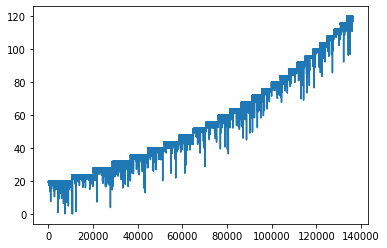

In [44]:
import matplotlib.pyplot as plt

plt.plot(range(len(max_hours)), max_hours)
plt.show()

In [35]:
from collections import Counter

# forecasting observation window bins
Counter(hours)

Counter({20: 10440,
         24: 9546,
         28: 8716,
         32: 8088,
         36: 7695,
         40: 7294,
         44: 6822,
         48: 6292,
         52: 5792,
         56: 5456,
         60: 5260,
         64: 5061,
         68: 4780,
         72: 4466,
         76: 4169,
         80: 3982,
         84: 3852,
         88: 3739,
         92: 3586,
         96: 3399,
         100: 3262,
         104: 3101,
         108: 3024,
         112: 2944,
         116: 2824,
         120: 2703})

<Axes: >

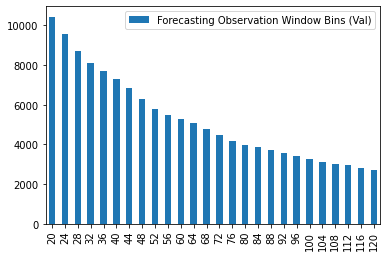

In [45]:
# visualize bins
df = pd.DataFrame.from_dict(Counter(hours), orient='index', columns=['Forecasting Observation Window Bins (Val)'])
df.plot.bar()

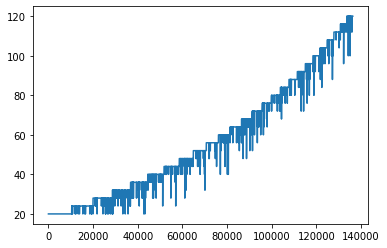

In [43]:
plt.clf()
plt.plot(range(len(hours)), hours)
plt.show()

In [36]:
len(hours)

136293

In [38]:
len(fore_valid_ip[1])

136293

### Val input inds

In [29]:
# get inds
val_inds = []

for ind in valid_ind:
    val_inds.append(fore_inds[ind])

### Val patient ids

In [41]:
# get patient ids
val_patient_ids = []
val_sepsis_labels = []

# sub_ids = oc['SUBJECT_ID'].tolist()
# ts_ind = oc['ts_ind'].tolist()
# sepsis = oc['in_hospital_sepsis'].tolist()

# for ind in val_inds:
#    for i in range(len(sub_ids)):
#      if ts_ind[i] == ind:
#        val_sepsis_labels.append(sepsis[i])
#        val_patient_ids.append(sub_ids[i])
#        break

for ind in val_inds:
  val_sepsis_labels.append(oc[oc['ts_ind']==ind]['in_hospital_sepsis'].item())
  val_patient_ids.append(oc[oc['ts_ind']==ind]['SUBJECT_ID'].item())

### output to pkl

In [42]:
val_data = pd.DataFrame(
    {'ts_ind': val_inds,
     'obs_window': hours,
     'SUBJECT_ID': val_patient_ids,
     'sepsis_label': val_sepsis_labels,
     'forecasting_pred': pd.Series(valid_y_preds.tolist())
    })

In [43]:
val_data

,ts_ind,obs_window,SUBJECT_ID,sepsis_label,forecasting_pred
0,1,20,270,0,"[-0.1630447655916214, 0.048375070095062256, -0..."
1,2,20,271,0,"[-0.05591287091374397, -0.3698490560054779, -0..."
2,5,20,274,0,"[-0.09906414896249771, 0.6817415952682495, -0...."
3,6,20,276,0,"[-0.5882726907730103, -0.392268568277359, -0.2..."
4,10,20,283,0,"[-0.24801766872406006, -0.20963838696479797, -..."
...,...,...,...,...,...
136288,56744,120,84853,0,"[-0.34762904047966003, -0.36281928420066833, -..."
136289,56898,120,12619,1,"[0.476502001285553, -0.7602043151855469, -0.63..."
136290,57009,120,69375,0,"[0.45679473876953125, -0.7679835557937622, -0...."
136291,57166,120,95022,0,"[-0.33411648869514465, -0.6584261655807495, -0..."


In [44]:
# dump to pkl
pickle.dump([val_data, var_to_ind], open('forecasting_preds_val.pkl','wb'))

In [45]:
# val_data, var_to_ind = pickle.load(open('/content/forecasting_preds_val.pkl', 'rb'))

## Test

### Load data

In [6]:
! unzip /content/drive/MyDrive/sepsis/strats_exp/data/sepsis_data/pre_text/sepsis_pretext_large_processed.pkl.zip

Archive:  /content/drive/MyDrive/sepsis/strats_exp/data/sepsis_data/pre_text/sepsis_pretext_large_processed.pkl.zip
  inflating: content/sepsis_pretext_large_processed.pkl  


In [7]:
# load data from new pkl 
data, oc, train_ind, valid_ind, test_ind = pickle.load(open('/content/content/sepsis_pretext_large_processed.pkl', 'rb'))

### Load test data into matrices

In [10]:
pred_window = 2 # hours
obs_windows = range(20, 124, 4)

# Remove train, val patients
data = data.merge(oc[['ts_ind', 'SUBJECT_ID']], on='ts_ind', how='left')
train_sub = oc.loc[oc.ts_ind.isin(train_ind)].SUBJECT_ID.unique()
valid_sub = oc.loc[oc.ts_ind.isin(valid_ind)].SUBJECT_ID.unique()
data = data.loc[~data.SUBJECT_ID.isin(train_sub)]
data = data.loc[~data.SUBJECT_ID.isin(valid_sub)]
oc = oc.loc[~oc.SUBJECT_ID.isin(train_sub)]
oc = oc.loc[~oc.SUBJECT_ID.isin(valid_sub)]

data.drop(columns=['SUBJECT_ID', 'TABLE'], inplace=True)
# Fix age.
data.loc[(data.variable=='Age')&(data.value>200), 'value'] = 91.4
# Get static data with mean fill and missingness indicator.
static_varis = ['Age', 'Gender']
ii = data.variable.isin(static_varis)
static_data = data.loc[ii]
data = data.loc[~ii]
def inv_list(l, start=0):
    d = {}
    for i in range(len(l)):
        d[l[i]] = i+start
    return d
static_var_to_ind = inv_list(static_varis)
D = len(static_varis)
N = data.ts_ind.max()+1
demo = np.zeros((N, D))
for row in tqdm(static_data.itertuples()):
    demo[row.ts_ind, static_var_to_ind[row.variable]] = row.value
# Normalize static data.
means = demo.mean(axis=0, keepdims=True)
stds = demo.std(axis=0, keepdims=True)
stds = (stds==0)*1 + (stds!=0)*stds
demo = (demo-means)/stds

# Get variable indices.
varis = sorted(list(set(data.variable)))
V = len(varis)
var_to_ind = inv_list(varis, start=1)
data['vind'] = data.variable.map(var_to_ind)
data = data[['ts_ind', 'vind', 'hour', 'value']].sort_values(by=['ts_ind', 'vind', 'hour'])
# Find max_len.
fore_max_len = 880
# Get forecast inputs and outputs.
fore_times_ip = []
fore_values_ip = []
fore_varis_ip = []
fore_op = []
fore_inds = []
def f(x):
    mask = [0 for i in range(V)]
    values = [0 for i in range(V)]
    for vv in x:
        v = int(vv[0])-1
        mask[v] = 1
        values[v] = vv[1]
    return values+mask
def pad(x):
    return x+[0]*(fore_max_len-len(x))

22938it [00:00, 303421.68it/s]


In [11]:
for w in tqdm(obs_windows):
    pred_data = data.loc[(data.hour>=w)&(data.hour<=w+pred_window)]
    pred_data = pred_data.groupby(['ts_ind', 'vind']).agg({'value':'first'}).reset_index()
    pred_data['vind_value'] = pred_data[['vind', 'value']].values.tolist()
    pred_data = pred_data.groupby('ts_ind').agg({'vind_value':list}).reset_index()
    pred_data['vind_value'] = pred_data['vind_value'].apply(f)    
    obs_data = data.loc[(data.hour<w)&(data.hour>=w-24)]
    obs_data = obs_data.loc[obs_data.ts_ind.isin(pred_data.ts_ind)]
    obs_data = obs_data.groupby('ts_ind').head(fore_max_len)
    obs_data = obs_data.groupby('ts_ind').agg({'vind':list, 'hour':list, 'value':list}).reset_index()
    obs_data = obs_data.merge(pred_data, on='ts_ind')
    for col in ['vind', 'hour', 'value']:
        obs_data[col] = obs_data[col].apply(pad)
    fore_op.append(np.array(list(obs_data.vind_value)))
    fore_inds.append(np.array(list(obs_data.ts_ind)))
    fore_times_ip.append(np.array(list(obs_data.hour)))
    fore_values_ip.append(np.array(list(obs_data.value)))
    fore_varis_ip.append(np.array(list(obs_data.vind)))

100%|██████████| 26/26 [01:21<00:00,  3.15s/it]


In [12]:
del data
fore_times_ip = np.concatenate(fore_times_ip, axis=0)
fore_values_ip = np.concatenate(fore_values_ip, axis=0)
fore_varis_ip = np.concatenate(fore_varis_ip, axis=0)
fore_op = np.concatenate(fore_op, axis=0)
fore_inds = np.concatenate(fore_inds, axis=0)
fore_demo = demo[fore_inds]

In [46]:
# # Get train and valid ts_ind for forecast task.
# test_sub = oc.loc[oc.ts_ind.isin(test_ind)].SUBJECT_ID.unique()
# rem_sub = oc.loc[~oc.SUBJECT_ID.isin(test_ind)].SUBJECT_ID.unique()
# bp = int(0.8*len(rem_sub))
# test_sub = np.concatenate((test_sub, rem_sub[:bp]))
# test_ind = oc.loc[oc.SUBJECT_ID.isin(test_sub)].ts_ind.unique() 

In [13]:
fore_test_ip = [fore_demo, fore_times_ip, fore_values_ip, fore_varis_ip]
fore_test_op = fore_op

In [14]:
# release RAM
del fore_times_ip, fore_values_ip, fore_varis_ip, demo, fore_demo

### get test `y_preds`

In [53]:
fore_savepath = 'mimic_iii_24h_strats_no_interp_with_ss_fore.h5'

lr, batch_size, samples_per_epoch, patience = 0.0005, 32, 102400, 5
d, N, he, dropout = 50, 2, 4, 0.2
model, fore_model =  build_strats(D, fore_max_len, V, d, N, he, dropout, forecast=True)
# print(fore_model.summary())
fore_model.compile(loss=forecast_loss, optimizer=Adam(lr))
fore_model.load_weights(fore_savepath)

test_y_preds = fore_model.predict(fore_test_ip)

4104/4104 [==============================] - 41s 10ms/step


### `var_to_ind` mapping

In [56]:
var_to_ind

{'ALP': 1,
 'ALT': 2,
 'AST': 3,
 'Albumin': 4,
 'Albumin 25%': 5,
 'Albumin 5%': 6,
 'Amiodarone': 7,
 'Anion Gap': 8,
 'Antibiotics': 9,
 'BUN': 10,
 'Base Excess': 11,
 'Basophils': 12,
 'Bicarbonate': 13,
 'Bilirubin (Direct)': 14,
 'Bilirubin (Indirect)': 15,
 'Bilirubin (Total)': 16,
 'Blood Culture': 17,
 'CRR': 18,
 'Calcium Free': 19,
 'Calcium Gluconate': 20,
 'Calcium Total': 21,
 'Cefazolin': 22,
 'Chest Tube': 23,
 'Chloride': 24,
 'Colloid': 25,
 'Creatinine Blood': 26,
 'Creatinine Urine': 27,
 'D5W': 28,
 'DBP': 29,
 'Dextrose Other': 30,
 'Dopamine': 31,
 'EBL': 32,
 'Emesis': 33,
 'Eoisinophils': 34,
 'Epinephrine': 35,
 'Famotidine': 36,
 'Fentanyl': 37,
 'FiO2': 38,
 'Fiber': 39,
 'Free Water': 40,
 'Fresh Frozen Plasma': 41,
 'Furosemide': 42,
 'GCS_eye': 43,
 'GCS_motor': 44,
 'GCS_verbal': 45,
 'GT Flush': 46,
 'Gastric': 47,
 'Gastric Meds': 48,
 'Glucose (Blood)': 49,
 'Glucose (Serum)': 50,
 'Glucose (Whole Blood)': 51,
 'HR': 52,
 'Half Normal Saline': 53,
 '

### Test input observation windows

In [54]:
hours = []
max_hours = []
# get hours
for time in fore_test_ip[1]:
  hour = max(time)
  max_hours.append(hour)
  
  for obs_window in obs_windows:
    if hour < obs_window:
      hour = obs_window
      break
  
  hours.append(hour)

<Axes: >

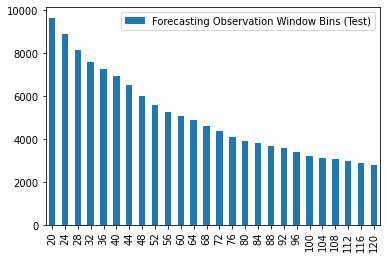

In [79]:
# visualization 
df = pd.DataFrame.from_dict(Counter(hours), orient='index', columns=['Forecasting Observation Window Bins (Test)'])
df.plot.bar()

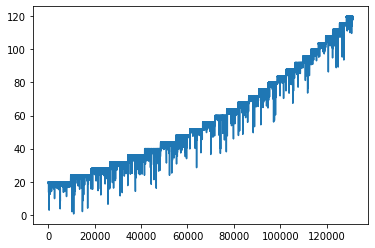

In [80]:
import matplotlib.pyplot as plt

plt.plot(range(len(max_hours)), max_hours)
plt.show()

### patient ids, sepsis labels

In [57]:
# get patient ids
test_patient_ids = []
test_sepsis_labels = []

# sub_ids = oc['SUBJECT_ID'].tolist()
# ts_ind = oc['ts_ind'].tolist()
# sepsis = oc['in_hospital_sepsis'].tolist()

# for ind in val_inds:
#    for i in range(len(sub_ids)):
#      if ts_ind[i] == ind:
#        val_sepsis_labels.append(sepsis[i])
#        val_patient_ids.append(sub_ids[i])
#        break

for ind in fore_inds:
  test_sepsis_labels.append(oc[oc['ts_ind']==ind]['in_hospital_sepsis'].item())
  test_patient_ids.append(oc[oc['ts_ind']==ind]['SUBJECT_ID'].item())

### output to pkl

In [60]:
test_data = pd.DataFrame(
    {'ts_ind': fore_inds,
     'obs_window': hours,
     'SUBJECT_ID': test_patient_ids,
     'sepsis_label': test_sepsis_labels,
     'forecasting_pred': pd.Series(test_y_preds.tolist()),
     'forecasting_test_op': pd.Series(fore_op.tolist())
    })

In [70]:
test_data

,ts_ind,obs_window,SUBJECT_ID,sepsis_label,forecasting_pred,forecasting_test_op
0,3,20,272,0,"[-0.7563478350639343, -0.2769825756549835, -0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,7,20,279,1,"[0.3193117380142212, -0.22587063908576965, -0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,9,20,281,0,"[0.47262197732925415, -0.5889627933502197, -0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,32,20,306,0,"[-0.2669658064842224, -0.2691204249858856, 0.1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,37,20,310,0,"[-0.31633082032203674, -0.21901646256446838, -...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...
131316,55274,120,43098,0,"[-0.38975512981414795, -0.6735785007476807, -0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
131317,55441,120,58826,1,"[0.4758621156215668, -0.8170661926269531, -0.6...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
131318,56391,120,23560,1,"[0.4496254026889801, -0.8427609205245972, -0.6...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
131319,56406,120,48388,1,"[0.47397905588150024, -0.8081768751144409, -0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."


In [62]:
# dump to pkl
pickle.dump([test_data, var_to_ind], open('forecasting_preds_test.pkl','wb'))

#### zip and save to g-drive

In [82]:
! zip '/content/forecasting_preds_test.pkl.zip' '/content/forecasting_preds_test.pkl'

  adding: content/forecasting_preds_test.pkl (deflated 79%)


In [83]:
! zip '/content/forecasting_preds_val.pkl.zip' '/content/forecasting_preds_val.pkl'

  adding: content/forecasting_preds_val.pkl (deflated 50%)


In [84]:
! zip '/content/sepsis_pretext_large_processed.pkl.zip' '/content/sepsis_pretext_large_processed.pkl'

  adding: content/sepsis_pretext_large_processed.pkl (deflated 88%)


In [85]:
# save to g drive
!cp -r '/content/forecasting_preds_test.pkl.zip' '/content/drive/MyDrive/sepsis/strats_exp'
!cp -r '/content/forecasting_preds_val.pkl.zip' '/content/drive/MyDrive/sepsis/strats_exp'
!cp -r '/content/sepsis_pretext_large_processed.pkl.zip' '/content/drive/MyDrive/sepsis/strats_exp'